In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.neighbors import LocalOutlierFactor

In [38]:
# Mengimpor dataset
df = pd.read_csv('/content/insurance.csv' , encoding='cp1254')  # Pandas kütüphanesinin read_csv fonksiyonu ile .csv dosyasını okur. 'cp1254' encoding, Türkçe karakterleri düzgün okuyabilmek için kullanılır.
df.head()  # Verinin ilk 5 satırını görüntüler


,yaş,cinsiyet,vucut_kitle_indeksi,cocuk_sayisi,sigara_kullanimi,bölge,sigorta_ücretleri
0,19,kadın,27.900,0,evet,güneybatı,16884.92400
1,18,erkek,33.770,1,hayır,güneydogu,1725.55230
2,28,erkek,33.000,3,hayır,güneydogu,4449.46200
3,33,erkek,22.705,0,hayır,kuzeybatı,21984.47061
4,32,erkek,28.880,0,hayır,kuzeybatı,3866.85520


In [39]:
# Kolon bilgilerini saklamak için boş listeler oluşturuluyor
kolonlar = []
benzersiz_sayisi = []
benzersiz_degerler = []
kolon_tipi = []

# DataFrame'in her bir kolonu için döngü başlatılıyor
for kolon in df.columns:
    kolonlar.append(kolon)  # Kolon adını listeye ekle
    benzersiz_sayisi.append(df[kolon].nunique())  # Kolonun benzersiz değer sayısını ekle
    benzersiz_degerler.append(df[kolon].unique())  # Kolonun benzersiz değerlerini ekle
    kolon_tipi.append(df[kolon].dtype)  # Kolonun veri tipini ekle

# Elde edilen bilgileri bir DataFrame'e dönüştür
kolon_dict = {'Kolon': kolonlar, 'Benzersiz Değer Sayısı': benzersiz_sayisi, 'Benzersiz Değerler': benzersiz_degerler, 'Veri Tipi': kolon_tipi}
pd.DataFrame(kolon_dict)


,Kolon,Benzersiz Değer Sayısı,Benzersiz Değerler,Veri Tipi
0,yaş,47,"[19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 2...",int64
1,cinsiyet,2,"[kadın, erkek]",object
2,vucut_kitle_indeksi,548,"[27.9, 33.77, 33.0, 22.705, 28.88, 25.74, 33.4...",float64
3,cocuk_sayisi,6,"[0, 1, 3, 2, 5, 4]",int64
4,sigara_kullanimi,2,"[evet, hayır]",object
5,bölge,4,"[güneybatı, güneydogu, kuzeybatı, kuzeydogu]",object
6,sigorta_ücretleri,1337,"[16884.924, 1725.5523, 4449.462, 21984.47061, ...",float64


In [40]:
# Kategorik ve sayısal kolonları ayırma

# Kategorik veri tipindeki kolonları seç
kategorik_kolonlar = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Sayısal veri tipindeki kolonları seç
sayisal_kolonlar = df.select_dtypes(exclude=['object', 'category']).columns.tolist()


In [41]:
# IQR yöntemiyle outlier (aykırı değer) tespiti

# 'charges' kolonunun 1. çeyrek (Q1) ve 3. çeyrek (Q3) değerlerini hesapla
Q1 = df['sigorta_ücretleri'].quantile(0.25)
Q3 = df['sigorta_ücretleri'].quantile(0.75)

# IQR (Çeyrekler Arası Mesafe) hesapla
IQR = Q3 - Q1

# Alt ve üst sınırları belirle
alt_sinir = Q1 - 1.5 * IQR
ust_sinir = Q3 + 1.5 * IQR

# Outlier'ları belirle
aykiri_degerler = (df['sigorta_ücretleri'] < alt_sinir) | (df['sigorta_ücretleri'] > ust_sinir)

# Aykırı değerlerin sayısını yazdır
print(f"IQR'ye göre tespit edilen aykırı değer sayısı: {len(df[aykiri_degerler])}")


IQR'ye göre tespit edilen aykırı değer sayısı: 139


In [42]:
# Z-Score yöntemiyle outlier (aykırı değer) tespiti

# 'sigorta_ücretleri' kolonunun ortalamasını ve standart sapmasını hesapla
ortalama = df['sigorta_ücretleri'].mean()
std_sapma = df['sigorta_ücretleri'].std()

# Z-Score için eşik değeri belirle
esik = 3

# Z-Score ile aykırı değerleri tespit et
aykiri_degerler_zscore = (abs((df['sigorta_ücretleri'] - ortalama) / std_sapma) > esik)

# Z-Score yöntemine göre aykırı değerlerin sayısını yazdır
print(f"Z-Score'a göre tespit edilen aykırı değer sayısı: {len(df[aykiri_degerler_zscore])}")

# IQR yöntemine göre aykırı değerlerin bulunması için outlier_iqr'yi tekrar kullan
outlier_iqr = (df['sigorta_ücretleri'] < alt_sinir) | (df['sigorta_ücretleri'] > ust_sinir)

# IQR ve Z-Score yöntemlerine göre ortak aykırı değerleri (univariate) tespit et
ortak_aykiri_degerler_univariate = outlier_iqr & aykiri_degerler_zscore

# Ortak aykırı değerlerin sayısını yazdır
print(f"Ortak aykırı değerler (univariate): {len(df[ortak_aykiri_degerler_univariate])}")


Z-Score'a göre tespit edilen aykırı değer sayısı: 7
Ortak aykırı değerler (univariate): 7


In [43]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# Isolation Forest ile outlier (aykırı değer) tespiti
clf = IsolationForest()
clf.fit(df[sayisal_kolonlar])  # Sayısal kolonlarla model eğitimi yap
outliers_if = clf.predict(df[sayisal_kolonlar])  # Aykırı değer tahminleri

# Local Outlier Factor (LOF) ile outlier tespiti
lof = LocalOutlierFactor(n_neighbors=10)
outliers_lof = lof.fit_predict(df[sayisal_kolonlar])  # LOF ile aykırı değer tahminleri

# Multivariat yöntemle ortak aykırı değerleri tespit et
ortak_aykiri_degerler_multivariate = (outliers_if == -1) & (outliers_lof == -1)

# Ortak aykırı değerlerin sayısını yazdır
print(f"Multivariat yöntemle tespit edilen ortak aykırı değer sayısı: {len(df[ortak_aykiri_degerler_multivariate])}")

# IQR ve Z-Score yöntemlerine göre aykırı değerlerin ortaklarını univariate tespitiyle bul
final_aykiri_degerler = df[ortak_aykiri_degerler_univariate & ortak_aykiri_degerler_multivariate]

# Final aykırı değerlerin sayısını yazdır
print(f"Final aykırı değer sayısı: {len(final_aykiri_degerler)}")


Multivariat yöntemle tespit edilen ortak aykırı değer sayısı: 13
Final aykırı değer sayısı: 7


In [44]:
# Aykırı değerleri (outliers) veri setinden çıkarma
df = df[~ortak_aykiri_degerler_univariate]  # Ortak aykırı değerleri çıkar

# Aykırı değerler çıkarıldıktan sonra veri setinin yeni boyutunu yazdır
print(f"Aykırı değerler çıkarıldıktan sonraki veri setinin boyutu: {df.shape}")


Aykırı değerler çıkarıldıktan sonraki veri setinin boyutu: (1331, 7)


In [45]:
from sklearn.preprocessing import LabelEncoder

# Kategorik kolonlar için encoding (etiketleme) işlemi

encode = LabelEncoder()

# 'sex', 'smoker' ve 'region' kolonlarını encode et
df['cinsiyet'] = encode.fit_transform(df['cinsiyet'])  # 'cinsiyet' kolonunu encode et
df['sigara_kullanimi'] = encode.fit_transform(df['sigara_kullanimi'])  # 'sigara_kullanimi' kolonunu encode et
df['bölge'] = encode.fit_transform(df['bölge'])  # 'bölge' kolonunu encode et

df  # Veri çerçevesini göster


,yaş,cinsiyet,vucut_kitle_indeksi,cocuk_sayisi,sigara_kullanimi,bölge,sigorta_ücretleri
0,19,1,27.900,0,0,0,16884.92400
1,18,0,33.770,1,1,1,1725.55230
2,28,0,33.000,3,1,1,4449.46200
3,33,0,22.705,0,1,2,21984.47061
4,32,0,28.880,0,1,2,3866.85520
...,...,...,...,...,...,...,...
1333,50,0,30.970,3,1,2,10600.54830
1334,18,1,31.920,0,1,3,2205.98080
1335,18,1,36.850,0,1,1,1629.83350
1336,21,1,25.800,0,1,0,2007.94500


In [46]:
from sklearn.model_selection import train_test_split

# Bağımlı ve bağımsız değişkenlerin belirlenmesi
y = df.pop('sigorta_ücretleri')  # 'charges' kolonunu bağımlı değişken olarak al
x = df  # Geriye kalan tüm kolonları bağımsız değişkenler olarak al

# Veri setini eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)



In [47]:
from sklearn.preprocessing import PolynomialFeatures

# Linear Regression için Polynomial Features (Polinom Özellikleri) oluşturma
poly = PolynomialFeatures(degree=2, include_bias=False)  # Polinom derecesini 2 olarak ayarla

# Eğitim ve test setleri için polinom özelliklerini oluştur
X_train_poly = poly.fit_transform(X_train)  # Eğitim setine polinom özelliklerini uygula
X_test_poly = poly.transform(X_test)  # Test setine polinom özelliklerini uygula


In [48]:
from sklearn.linear_model import LinearRegression

# Lineer Regresyon modelini eğitme
model = LinearRegression()  # Lineer regresyon modelini oluştur
model.fit(X_train_poly, y_train)  # Eğitim setiyle modeli eğit


LinearRegression()

In [49]:
# Lineer Regresyon ile tahmin yapma
y_tahmin_poly = model.predict(X_test_poly)  # Test seti için tahmin yap
train_tahmin_poly = model.predict(X_train_poly)  # Eğitim seti için tahmin yap


In [50]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Lineer Regresyon için değerlendirme metrikleri
rmse_poly = np.sqrt(mean_squared_error(y_test, y_tahmin_poly))  # Kök Ortalama Kare Hata (RMSE)
r2_poly = r2_score(y_test, y_tahmin_poly)  # R-Kare (R²) skoru
explained_var_poly = explained_variance_score(y_test, y_tahmin_poly)  # Açıklanan Varyans

# Sonuçları yazdır
print("Lineer Regresyon ile Polinom Özellikleri\n")
print(f"RMSE: {rmse_poly}")
print(f"R-Kare: {r2_poly}")
print(f"Açıklanan Varyans: {explained_var_poly}")


Lineer Regresyon ile Polinom Özellikleri

RMSE: 4503.143401470309
R-Kare: 0.8722756233537974
Açıklanan Varyans: 0.8723573319306637


In [51]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Random Forest modelini oluşturma
rf = RandomForestRegressor(random_state=42)  # Modeli oluştur

# Random Forest için hiperparametre aralıkları
param_rf = {
    'n_estimators': np.arange(50, 500, 50),  # Ağaç sayısı (50 ile 500 arasında, 50'lik artışlarla)
    'max_depth': np.arange(3, 15, 1),  # Ağaç derinliği (3 ile 15 arasında, 1'lik artışlarla)
    'min_samples_leaf': np.arange(2, 15, 5),  # Minimum örnek sayısı (dal yaprağında)
    'min_samples_split': [3, 5, 10, 15],  # Minimum örnek sayısı (dallanma için)
    'bootstrap': [True, False],  # Bootstrap örnekleme
    'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],  # Hata ölçütleri
}

# Sözlüğü doğru bir şekilde kapatmayı unutmayın


In [52]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest için RandomizedSearchCV ile hiperparametre optimizasyonu
rf_search = RandomizedSearchCV(rf, param_rf, cv=5, n_jobs=-1, verbose=0, scoring='neg_mean_squared_error', n_iter=100)

# Eğitim seti ile RandomizedSearchCV'yi eğit
rf_search.fit(X_train, y_train)

# En iyi modeli seç
rf_model = rf_search.best_estimator_

In [53]:
# Random Forest modeli ile test verisi üzerinde tahmin yapma
y_tahmin_rf = rf_model.predict(X_test)


In [54]:
# Gerçek Y, Tahmin Edilen Y ve Hata'nın karşılaştırılması
comparison_df = pd.DataFrame({
    'Y_Asli': y_test,  # Gerçek değerler
    'Y_Prediksi': y_tahmin_rf,  # Tahmin edilen değerler
    'Error': y_test - y_tahmin_rf  # Gerçek ve tahmin edilen değer arasındaki fark (Hata)
})

# Sonuçları yazdırma
print("\nGerçek Y, Tahmin Edilen Y ve Hata Karşılaştırması\n")
print(comparison_df)



Gerçek Y, Tahmin Edilen Y ve Hata Karşılaştırması

           Y_Asli    Y_Prediksi         Error
950   11534.87265  12619.464100  -1084.591450
1131   3693.42800   5682.051595  -1988.623595
1239   3238.43570   5247.546193  -2009.110493
298   38746.35510  37075.284233   1671.070867
657    4058.71245   7455.978535  -3397.266085
...           ...           ...           ...
533   19214.70553   5135.866332  14078.839198
1200   6198.75180   7370.915427  -1172.163627
759   36307.79830  37938.440193  -1630.641893
1298   5261.46945   7321.216279  -2059.746829
1284  47403.88000  47214.847412    189.032588

[267 rows x 3 columns]


In [55]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import numpy as np

# Random Forest için değerlendirme metrikleri
rmse_rf = np.sqrt(mean_squared_error(y_test, y_tahmin_rf))  # Kök Ortalama Kare Hata (RMSE)
r2_rf = r2_score(y_test, y_tahmin_rf)  # R-Kare (R²) skoru
explained_var_rf = explained_variance_score(y_test, y_tahmin_rf)  # Açıklanan Varyans

# Sonuçları yazdırma
print("\nRandom Forest\n")
print(f"RMSE: {rmse_rf}")
print(f"R-Kare: {r2_rf}")
print(f"Açıklanan Varyans: {explained_var_rf}")


Random Forest

RMSE: 4278.417642265108
R-Kare: 0.8847054999891255
Açıklanan Varyans: 0.8847129590274405


In [56]:
# Linear Regression için polinomal özellikler ile tahmin yapma
y_pred_poly = model.predict(X_test_poly)

# Linear Regression için değerlendirme metrikleri
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))  # Kök Ortalama Kare Hata (RMSE)
r2_poly = r2_score(y_test, y_pred_poly)  # R-Kare (R²) skoru
explained_var_poly = explained_variance_score(y_test, y_pred_poly)  # Açıklanan Varyans

# Random Forest için değerlendirme metrikleri
rmse_rf = np.sqrt(mean_squared_error(y_test, y_tahmin_rf))  # Kök Ortalama Kare Hata (RMSE)
r2_rf = r2_score(y_test, y_tahmin_rf)  # R-Kare (R²) skoru
explained_var_rf = explained_variance_score(y_test, y_tahmin_rf)  # Açıklanan Varyans

# İki modelin karşılaştırılması
print("\nLinear Regression ve Random Forest Modeli Karşılaştırması\n")
print(f"{'Metric':<30}{'Linear Regression':<20}{'Random Forest':<20}")
print("-" * 70)
print(f"{'RMSE':<30}{rmse_poly:<20.4f}{rmse_rf:<20.4f}")
print(f"{'R-Kare':<30}{r2_poly:<20.4f}{r2_rf:<20.4f}")
print(f"{'Açıklanan Varyans':<30}{explained_var_poly:<20.4f}{explained_var_rf:<20.4f}")



Linear Regression ve Random Forest Modeli Karşılaştırması

Metric                        Linear Regression   Random Forest       
----------------------------------------------------------------------
RMSE                          4503.1434           4278.4176           
R-Kare                        0.8723              0.8847              
Açıklanan Varyans             0.8724              0.8847              


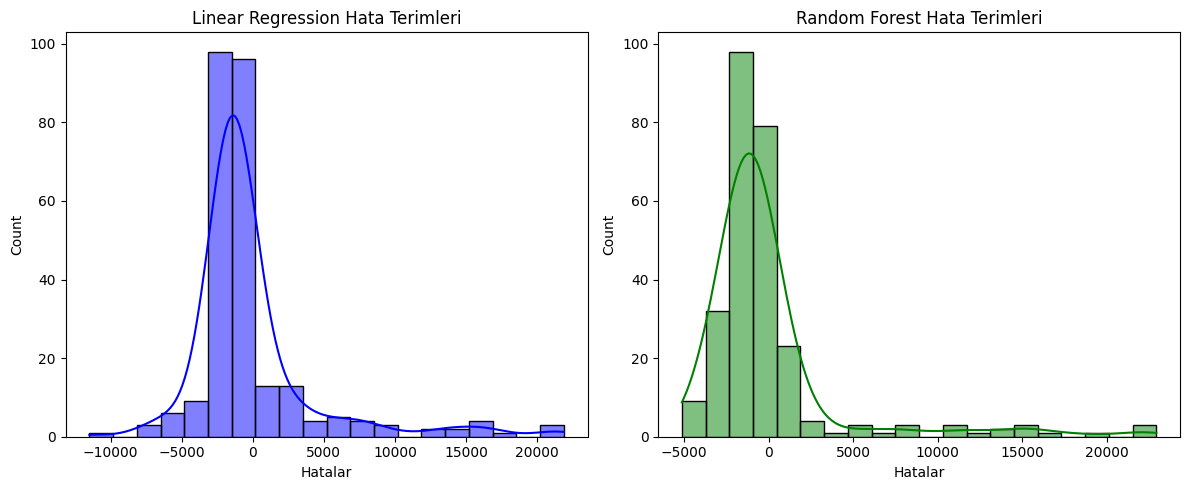

In [57]:
# Visualizasyon: Linear Regression ve Random Forest Hata Terimleri
plt.figure(figsize=(12, 5))

# Linear Regression Hata Terimleri
plt.subplot(1, 2, 1)
sns.histplot((y_test - y_pred_poly), bins=20, kde=True, color='blue')
plt.title('Linear Regression Hata Terimleri')
plt.xlabel('Hatalar')

# Random Forest Hata Terimleri
plt.subplot(1, 2, 2)
sns.histplot((y_test - y_tahmin_rf), bins=20, kde=True, color='green')
plt.title('Random Forest Hata Terimleri')
plt.xlabel('Hatalar')

# Grafiklerin düzeni
plt.tight_layout()
plt.show()


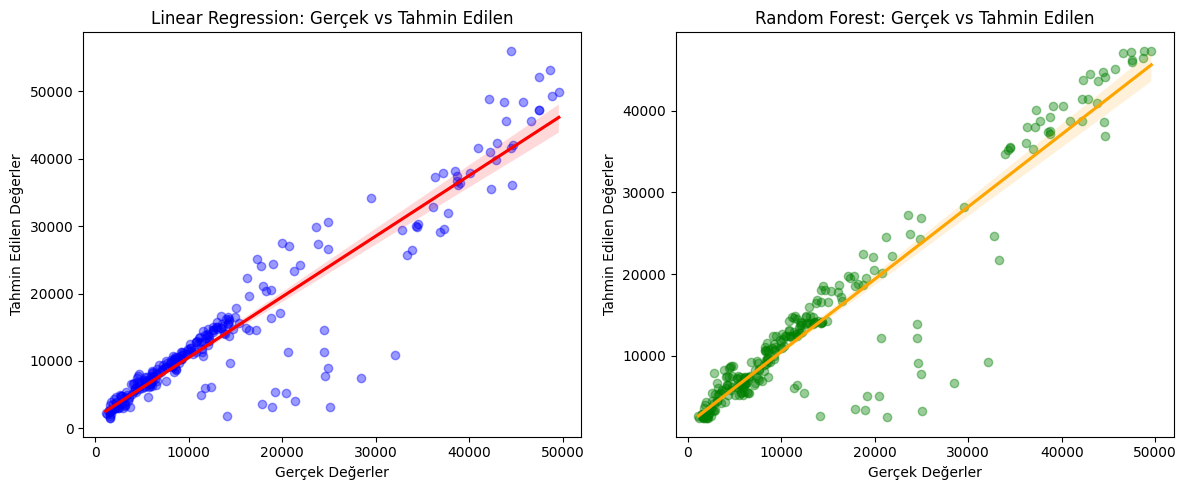

In [58]:

# Scatter Plot: Gerçek vs Tahmin Edilen
plt.figure(figsize=(12, 5))

# Linear Regression: Gerçek vs Tahmin Edilen
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=y_pred_poly, scatter_kws={'alpha': 0.4, 'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Linear Regression: Gerçek vs Tahmin Edilen')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')

# Random Forest: Gerçek vs Tahmin Edilen
plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=y_tahmin_rf, scatter_kws={'alpha': 0.4, 'color': 'green'}, line_kws={'color': 'orange'})
plt.title('Random Forest: Gerçek vs Tahmin Edilen')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')

# Grafiklerin düzeni
plt.tight_layout()
plt.show()